In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure
from matplotlib import font_manager as fm
import networks
import rsa
import editdistance
from pilot import utils
from scipy.spatial import distance
import seaborn as sns
import pickle
from tqdm import tqdm
from io import BytesIO
import os
import contextlib

In [2]:
def make_image(word, rotation=0, size=16, family='dejavu sans', fname=None, noise=0):
    # Create figure of exactly 64x64 pixels
    dpi = 96.
    f = Figure(figsize=(64 / dpi, 64 / dpi), dpi=dpi)
    
    # Initialize an empty figure
    f.clf()
    ax = f.add_axes([0, 0, 1, 1])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_axis_off()

    # Start with a grey background image
    background = plt.Rectangle((0, 0), 64, 64, facecolor=(0.5, 0.5, 0.5, 1.0), zorder=0)
    ax.add_patch(background)

    # Add noise to the image. Note the usage of the alpha parameter to tweak the amount of noise
    noise_image = np.random.randn(64, 64)
    ax.imshow(noise_image, extent=[0, 1, 0, 1], cmap='gray', alpha=noise, zorder=1)
    
    # Add the text to the image in the selected font
    fontprop = fm.FontProperties(family=family, fname=fname, size=size)
    ax.text(0.5, 0.5, word, ha='center', va='center',
            rotation=rotation, fontproperties=fontprop, alpha=1 - noise, zorder=2)

    # We need the canvas object to get the bitmap data at the end
    canvas = FigureCanvasAgg(f)
    
    # Render the image and create a PIL.Image from the pixel data
    canvas.draw()
    buffer, (width, height) = canvas.print_to_buffer()
    image = np.frombuffer(buffer, np.uint8).reshape((height, width, 4))[:, :, :3]
    image = Image.fromarray(image)
    
    # The preprocessing transform used during training of the model
    preproc = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(60),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.2, 0.2, 0.2]),
        ])
    
    # Transform the PIL image to a PyTorch tensor for feeding into the model
    image = preproc(image).unsqueeze(0)
    return image

# Create images with noises and see how CNN model gets activated

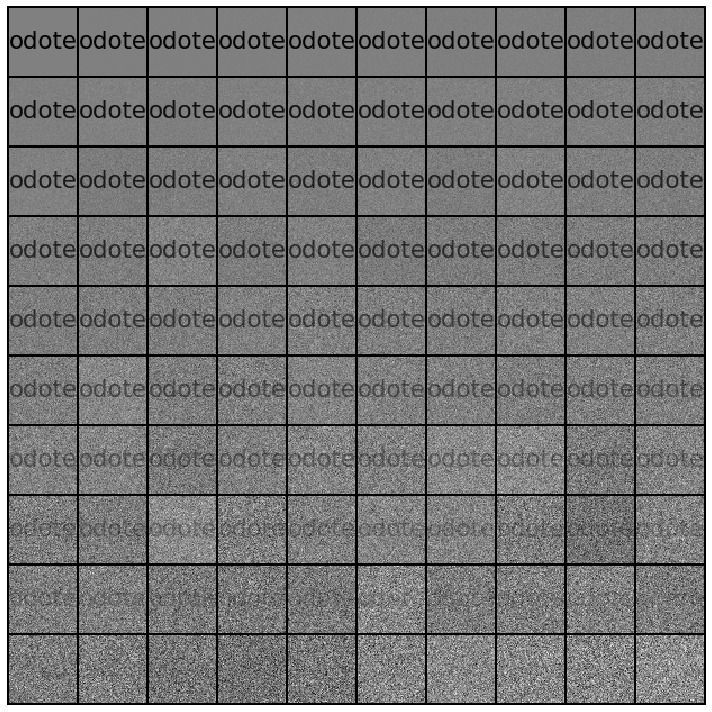

In [3]:
# Construct images
images_noise = []
for noise in np.arange(0, 1.0, 0.01):
    images_noise.append(make_image(word='odote', noise=noise))
images_noise = torch.cat(images_noise, 0)

# Plot the images
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.tight_layout()
plt.imshow(make_grid(images_noise/5 + 0.5, nrow=10).numpy().transpose(1, 2, 0));

### Get DSM

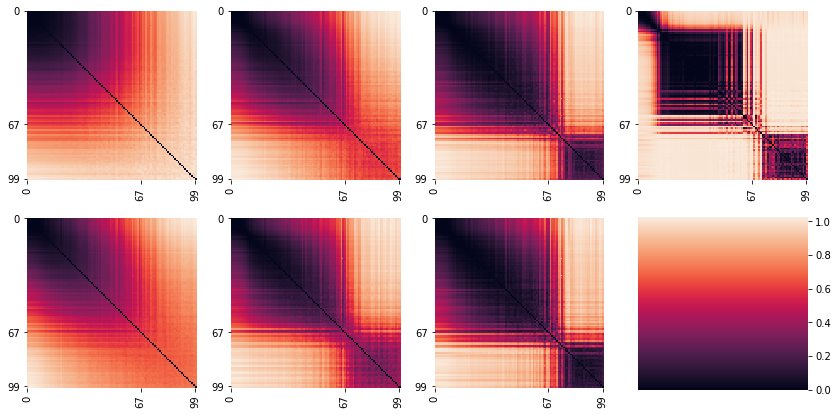

In [4]:
# Load the model and feed through the images
model_name = 'vgg_first_imagenet64_then_tiny-words-noisy_tiny-imagenet'
checkpoint = torch.load('%s.pth.tar' % model_name, map_location='cpu')
model = networks.vgg.from_checkpoint(checkpoint)
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    feature_outputs, classifier_outputs = model.get_layer_activations(images_noise)

# calculate DSMs
dsms_values = [
    rsa.compute_dsm(feature_outputs[0], metric='correlation'),
    rsa.compute_dsm(feature_outputs[1], metric='correlation'),
    rsa.compute_dsm(feature_outputs[2], metric='correlation'),
    rsa.compute_dsm(feature_outputs[3], metric='correlation'),
    rsa.compute_dsm(classifier_outputs[0], metric='correlation'),
    rsa.compute_dsm(classifier_outputs[1], metric='correlation'),
    rsa.compute_dsm(classifier_outputs[2], metric='correlation'),
]

fig, axes = plt.subplots(2, 4, figsize=(14, 7))
ticklabels = [0, 67, 99]

for i in range(len(dsms_values)):
    dsm = dsms_values[i]
    ax = axes[i%2, i//2]
    if i < len(dsms_values)-1:
        sns.heatmap(distance.squareform(dsm), ax=ax, cbar=False, square=True, xticklabels=ticklabels,
                   yticklabels=ticklabels)
    else:
        sns.heatmap(distance.squareform(dsm), ax=ax, cbar_ax=axes[1, 3], square=True, xticklabels=ticklabels,
                   yticklabels=ticklabels)
    ax.set_xticks(ticklabels)
    ax.set_yticks(ticklabels)

### Get RSA with pixel-wise DSM

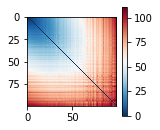

In [5]:
DSM_pixelwise_noise = rsa.compute_dsm(images_noise, metric='euclidean')
rsa.plot_dsms(DSM_pixelwise_noise);

In [6]:
rsa_noise = rsa.rsa(dsms_values, DSM_pixelwise_noise, metric='kendall-tau-a')
print(rsa_noise)

[0.9124608  0.73898565 0.68180296 0.58127894 0.58709961 0.53898476
 0.43513894]


### Where Are Noisy Images Classified?

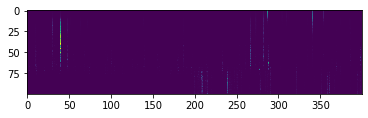

In [7]:
plt.imshow(classifier_outputs[-1]);

# Try the Same Thing for Different Fonts

In [8]:
def images_with_fonts(words, fonts, font_size=16):
    images = []
    
    for word in words:
        for font in fonts:
            fontfamily, fontfile = fonts[font]
            image = make_image(word, rotation=0, size=font_size, family=fontfamily, fname=fontfile, noise=0)
            images.append(image)
          
    return images

In [9]:
fonts = {
        'ubuntu mono': [None, 'data/fonts/UbuntuMono-R.ttf'],
        'courier': [None, 'data/fonts/courier.ttf'],
        'luxi mono regular': [None, 'data/fonts/luximr.ttf'],
        'lucida console': [None, 'data/fonts/LucidaConsole-R.ttf'],
        'lekton': [None, 'data/fonts/Lekton-Regular.ttf'],
        'dejavu sans mono': ['dejavu sans mono', None],
        'times new roman': [None, 'data/fonts/times.ttf'],
        'arial': [None, 'data/fonts/arial.ttf'],
        'arial black': [None, 'data/fonts/arialbd.ttf'],
        'verdana': [None, 'data/fonts/verdana.ttf'],
        'comic sans ms': [None, 'data/fonts/comic.ttf'],
        'georgia': [None, 'data/fonts/georgia.ttf'],
        'liberation serif': ['liberation serif', None],
        'impact': [None, 'data/fonts/impact.ttf'],
        'roboto condensed': [None, 'data/fonts/Roboto-Light.ttf'],
    }
images_font = torch.cat(images_with_fonts(['odote'], fonts, font_size=12), 0)

findfont: Font family ['liberation serif'] not found. Falling back to DejaVu Sans.


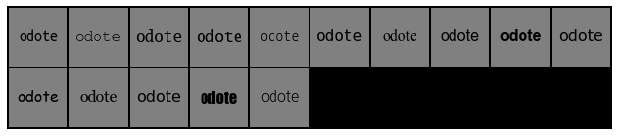

In [10]:
# Plot the images
plt.figure(figsize=(10, 2))
plt.axis('off')
plt.tight_layout()
plt.imshow(make_grid(images_font/5 + 0.5, nrow=10).numpy().transpose(1, 2, 0));

### Check DSM

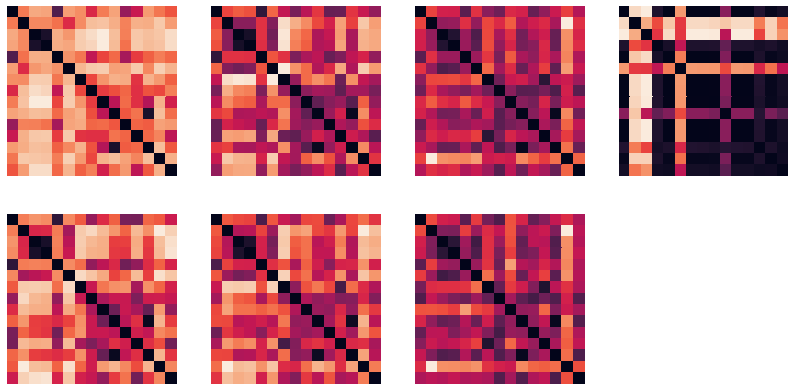

In [11]:
# Load the model and feed through the images
model_name = 'vgg_first_imagenet64_then_tiny-words-noisy_tiny-imagenet'
checkpoint = torch.load('%s.pth.tar' % model_name, map_location='cpu')
model = networks.vgg.from_checkpoint(checkpoint)
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    feature_outputs, classifier_outputs = model.get_layer_activations(images_font)

# calculate DSMs
dsms_values = [
    rsa.compute_dsm(feature_outputs[0], metric='correlation'),
    rsa.compute_dsm(feature_outputs[1], metric='correlation'),
    rsa.compute_dsm(feature_outputs[2], metric='correlation'),
    rsa.compute_dsm(feature_outputs[3], metric='correlation'),
    rsa.compute_dsm(classifier_outputs[0], metric='correlation'),
    rsa.compute_dsm(classifier_outputs[1], metric='correlation'),
    rsa.compute_dsm(classifier_outputs[2], metric='correlation'),
]

fig, axes = plt.subplots(2, 4, figsize=(14, 7))
ticklabels = []
axes[-1, -1].remove()

for i in range(len(dsms_values)):
    dsm = dsms_values[i]
    ax = axes[i%2, i//2]
    if i < len(dsms_values)-1:
        sns.heatmap(distance.squareform(dsm), ax=ax, cbar=False, square=True, xticklabels=ticklabels,
                   yticklabels=ticklabels)
    else:
        sns.heatmap(distance.squareform(dsm), ax=ax, cbar=False, square=True, xticklabels=ticklabels,
                   yticklabels=ticklabels)
    ax.set_xticks(ticklabels)
    ax.set_yticks(ticklabels)

### Find DSM for the raw images (over different fonts)

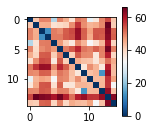

In [12]:
DSM_pixelwise_font = rsa.compute_dsm(images_font, metric='euclidean')
rsa.plot_dsms(DSM_pixelwise_font);

In [13]:
rsa_font = rsa.rsa(dsms_values, DSM_pixelwise_font, metric='kendall-tau-a')
print(rsa_font)

[0.66483516 0.53663004 0.4952381  0.48534799 0.40805861 0.38864469
 0.18864469]


# Do it again, for rotation!

In [14]:
rotations = range(0, 360, 30)

words = ["odote"]

images_rot = []
for word in words:
    for rot in rotations:
        image_rot = make_image(word, rotation=rot, size=12, noise=0)
        images_rot.append(image_rot)
images_rot = torch.cat(images_rot, 0)

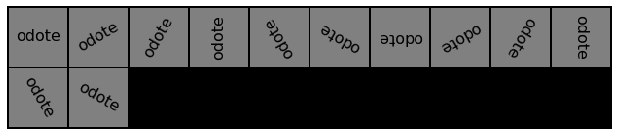

In [15]:
# Plot the images
plt.figure(figsize=(10, 2))
plt.axis('off')
plt.tight_layout()
plt.imshow(make_grid(images_rot/5 + 0.5, nrow=10).numpy().transpose(1, 2, 0));

In [16]:
# Load the model and feed through the images
model_name = 'vgg_first_imagenet64_then_tiny-words-noisy_tiny-imagenet'
checkpoint = torch.load('%s.pth.tar' % model_name, map_location='cpu')
model = networks.vgg.from_checkpoint(checkpoint)
feature_outputs, classifier_outputs = model.get_layer_activations(images_rot)

layer 00, output=torch.Size([12, 64, 60, 60])
layer 01, output=torch.Size([12, 64, 60, 60])
layer 02, output=torch.Size([12, 64, 60, 60])
layer 03, output=torch.Size([12, 64, 60, 60])
layer 04, output=torch.Size([12, 64, 60, 60])
layer 05, output=torch.Size([12, 64, 60, 60])
layer 06, output=torch.Size([12, 64, 30, 30])
layer 07, output=torch.Size([12, 128, 30, 30])
layer 08, output=torch.Size([12, 128, 30, 30])
layer 09, output=torch.Size([12, 128, 30, 30])
layer 10, output=torch.Size([12, 128, 30, 30])
layer 11, output=torch.Size([12, 128, 30, 30])
layer 12, output=torch.Size([12, 128, 30, 30])
layer 13, output=torch.Size([12, 128, 15, 15])
layer 14, output=torch.Size([12, 256, 15, 15])
layer 15, output=torch.Size([12, 256, 15, 15])
layer 16, output=torch.Size([12, 256, 15, 15])
layer 17, output=torch.Size([12, 256, 15, 15])
layer 18, output=torch.Size([12, 256, 15, 15])
layer 19, output=torch.Size([12, 256, 15, 15])
layer 20, output=torch.Size([12, 256, 7, 7])
layer 21, output=torch

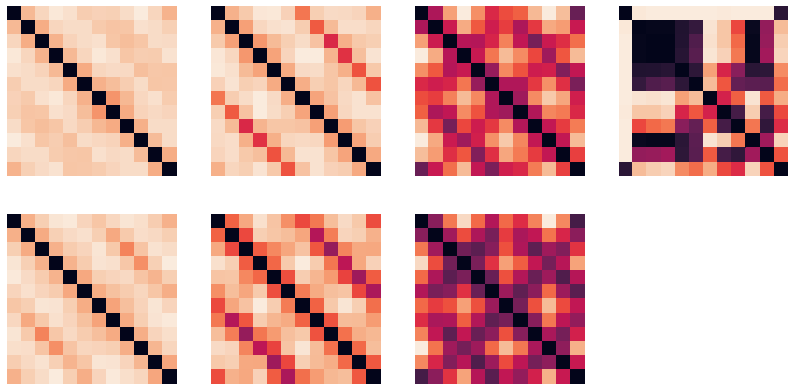

In [17]:
dsms_values = [
    rsa.compute_dsm(feature_outputs[0], metric='correlation'),
    rsa.compute_dsm(feature_outputs[1], metric='correlation'),
    rsa.compute_dsm(feature_outputs[2], metric='correlation'),
    rsa.compute_dsm(feature_outputs[3], metric='correlation'),
    rsa.compute_dsm(classifier_outputs[0], metric='correlation'),
    rsa.compute_dsm(classifier_outputs[1], metric='correlation'),
    rsa.compute_dsm(classifier_outputs[2], metric='correlation'),
]

fig, axes = plt.subplots(2, 4, figsize=(14, 7))
ticklabels = []
axes[-1, -1].remove()

for i in range(len(dsms_values)):
    dsm = dsms_values[i]
    ax = axes[i%2, i//2]
    if i < len(dsms_values)-1:
        sns.heatmap(distance.squareform(dsm), ax=ax, cbar=False, square=True, xticklabels=ticklabels,
                   yticklabels=ticklabels)
    else:
        sns.heatmap(distance.squareform(dsm), ax=ax, cbar=False, square=True, xticklabels=ticklabels,
                   yticklabels=ticklabels)
    ax.set_xticks(ticklabels)
    ax.set_yticks(ticklabels)

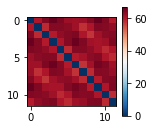

In [67]:
DSM_pixelwise_rot = rsa.compute_dsm(images_rot, metric='euclidean')
rsa.plot_dsms(DSM_pixelwise_rot);

In [19]:
rsa_rot = rsa.rsa(dsms_values, DSM_pixelwise_rot, metric='kendall-tau-a')
print(rsa_rot)

[0.77342657 0.67272727 0.65034965 0.68018648 0.67179487 0.52261072
 0.26153846]


# Lastly, try it for word length!

In [20]:
with open("meta", "rb") as f:
    meta = pickle.load(f)

In [21]:
# check word legnths
words = meta["label_names"]
lengths = words.apply(lambda x: len(x))
min_len = lengths.min()
max_len = lengths.max()
print(f"Word lengths are from {min_len} to {max_len}.")

Word lengths are from 2 to 6.


In [22]:
# pick one word for each word length
selected_words = [""]*(max_len-min_len+1)
for i in range(min_len, max_len+1):
    for j in lengths.index:
        l = lengths[j]
        if i==l:
            selected_words[i-min_len] = words[j]
            break

In [23]:
images_len=[]
for word in selected_words:
    image_len = make_image(word, rotation=0, size=12, noise=0)
    images_len.append(image_len)
images_len = torch.cat(images_len, 0)

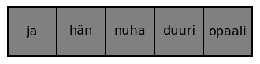

In [24]:
# Plot the images
plt.figure(figsize=(5, 1))
plt.axis('off')
plt.tight_layout()
plt.imshow(make_grid(images_len/5 + 0.5, nrow=5).numpy().transpose(1, 2, 0));

In [25]:
# Load the model and feed through the images
model_name = 'vgg_first_imagenet64_then_tiny-words-noisy_tiny-imagenet'
checkpoint = torch.load('%s.pth.tar' % model_name, map_location='cpu')
model = networks.vgg.from_checkpoint(checkpoint)
feature_outputs, classifier_outputs = model.get_layer_activations(images_len)

layer 00, output=torch.Size([5, 64, 60, 60])
layer 01, output=torch.Size([5, 64, 60, 60])
layer 02, output=torch.Size([5, 64, 60, 60])
layer 03, output=torch.Size([5, 64, 60, 60])
layer 04, output=torch.Size([5, 64, 60, 60])
layer 05, output=torch.Size([5, 64, 60, 60])
layer 06, output=torch.Size([5, 64, 30, 30])
layer 07, output=torch.Size([5, 128, 30, 30])
layer 08, output=torch.Size([5, 128, 30, 30])
layer 09, output=torch.Size([5, 128, 30, 30])
layer 10, output=torch.Size([5, 128, 30, 30])
layer 11, output=torch.Size([5, 128, 30, 30])
layer 12, output=torch.Size([5, 128, 30, 30])
layer 13, output=torch.Size([5, 128, 15, 15])
layer 14, output=torch.Size([5, 256, 15, 15])
layer 15, output=torch.Size([5, 256, 15, 15])
layer 16, output=torch.Size([5, 256, 15, 15])
layer 17, output=torch.Size([5, 256, 15, 15])
layer 18, output=torch.Size([5, 256, 15, 15])
layer 19, output=torch.Size([5, 256, 15, 15])
layer 20, output=torch.Size([5, 256, 7, 7])
layer 21, output=torch.Size([5, 512, 7, 7])

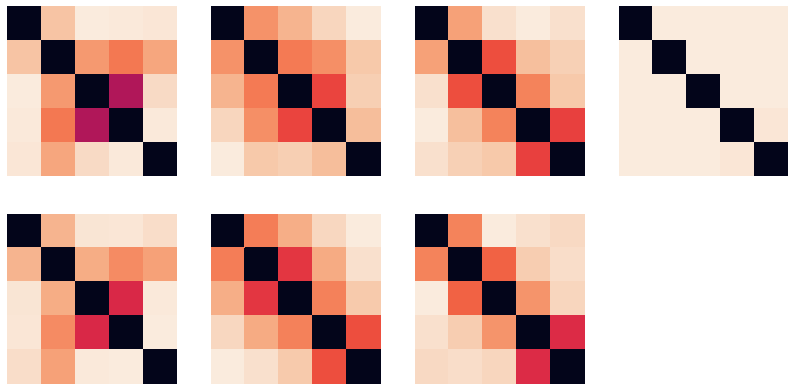

In [26]:
dsms_values = [
    rsa.compute_dsm(feature_outputs[0], metric='correlation'),
    rsa.compute_dsm(feature_outputs[1], metric='correlation'),
    rsa.compute_dsm(feature_outputs[2], metric='correlation'),
    rsa.compute_dsm(feature_outputs[3], metric='correlation'),
    rsa.compute_dsm(classifier_outputs[0], metric='correlation'),
    rsa.compute_dsm(classifier_outputs[1], metric='correlation'),
    rsa.compute_dsm(classifier_outputs[2], metric='correlation'),
]

fig, axes = plt.subplots(2, 4, figsize=(14, 7))
ticklabels = []
axes[-1, -1].remove()

for i in range(len(dsms_values)):
    dsm = dsms_values[i]
    ax = axes[i%2, i//2]
    if i < len(dsms_values)-1:
        sns.heatmap(distance.squareform(dsm), ax=ax, cbar=False, square=True, xticklabels=ticklabels,
                   yticklabels=ticklabels)
    else:
        sns.heatmap(distance.squareform(dsm), ax=ax, cbar=False, square=True, xticklabels=ticklabels,
                   yticklabels=ticklabels)
    ax.set_xticks(ticklabels)
    ax.set_yticks(ticklabels)

This is very interesting, the word length matters in the last layers the most!

In [27]:
DSM_pixelwise_len = rsa.compute_dsm(images_len, metric='euclidean')

In [28]:
rsa_len = rsa.rsa(dsms_values, DSM_pixelwise_len, metric='kendall-tau-a')
print(rsa_len)

[ 0.73333333  0.6         0.68888889  0.28888889  0.37777778  0.28888889
 -0.15555556]


Solid result, but shoudn't RSA result be absolute val?

# Summary of RSA analysis

In [35]:
layers = ["feature1", "feature2", "feature3", "feature4", "layer1", "layer2", "layer3"]
rsas = [rsa_noise, rsa_font, rsa_rot, rsa_len]

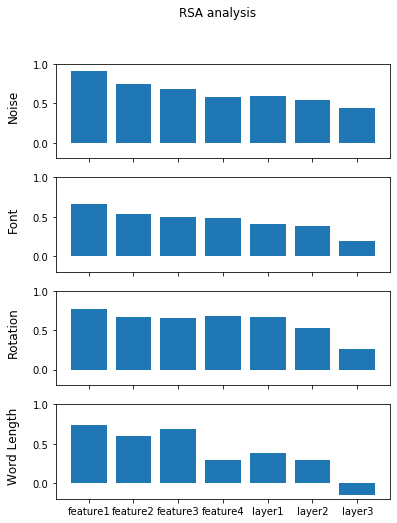

In [64]:
fig, axes = plt.subplots(4, sharex=True, sharey=True, figsize=(6, 8))
titles = ["Noise", "Font", "Rotation", "Word Length"]
fig.suptitle("RSA analysis")

for i in range(4):
    axes[i].bar(x=layers, height=rsas[i])
    axes[i].set_title(titles[i], fontdict={'verticalalignment': 'center'}, rotation='vertical', x=-0.125, y=0.5)
plt.setp(axes, ylim=(-0.2, 1));
plt.savefig("rsa_analysis.pdf")